### Render stac outputs with mujoco

In [1]:
#@title Check if MuJoCo installation was successful
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
   'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
# %env MUJOCO_GL=osmesa

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags


Sat Sep 21 15:58:12 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:41:00.0 Off |                  Off |
| 40%   68C    P2            116W /  300W |    2096MiB /  49140MiB |     97%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
%load_ext autoreload
%autoreload 2

# glfw is faster, but use osmesa if glfw not available
%env MUJOCO_GL=osmesa
%env PYOPENGL_PLATFORM=osmesa

import stac_mjx

import mediapy as media
from pathlib import Path
import os


# Disable jax's memory preallocation if you're running multiple notebooks using jax
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false" 

base_path = Path.cwd().parent
# stac_config_path = base_path / "configs/stac_free.yaml"
# model_config_path = base_path / "configs/flybody_free.yaml"
data_dir = Path('/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/')
stac_config_path = base_path / "configs/stac.yaml"
model_config_path = base_path / "configs/flybody.yaml"

cfg = stac_mjx.load_configs(base_path / "configs")

env: MUJOCO_GL=osmesa
env: PYOPENGL_PLATFORM=osmesa


2024-09-21 15:58:21.193962: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
import pandas as pd
tredmill_data = pd.read_csv(data_dir / "wt_berlin_linear_treadmill_dataset.csv")
kp_names = ['head', 'thorax', 'abdomen', 'r1', 'r2', 'r3', 'l1', 'l2', 'l3']
coords = ['_x', '_y', '_z']
df_names = [kp+coord for kp in kp_names for coord in coords]
kp_data_all = tredmill_data[df_names].values
sorted_kp_names = kp_names
kp_data = model_cfg['MOCAP_SCALE_FACTOR']*kp_data_all.copy()


In [6]:
kp_data.shape[0]/1800

581.0

In [22]:
# set args
data_path = base_path / "transform_free.p" 
# data_path = base_path / "transform_balljoint.p" 
n_frames = 100
camera=3
# save_path = base_path / ('videos/fly_free_camera{}.mp4'.format(camera))
save_path = base_path / ('videos/fly_camera{}.mp4'.format(camera))
# [100800:102599,:].
# Call mujoco_viz
frames = stac_mjx.viz_stac(data_path, stac_cfg, model_cfg, n_frames, save_path, start_frame=0, camera=camera, base_path=Path.cwd().parent)

# Show the video in the noteb ook (it is also saved to the save_path) 
media.show_video(frames, fps=50)  #model_cfg["RENDER_FPS"]

2024-09-11 16:15:04.481692: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
0it [00:00, ?it/s]/home/eabe/miniconda3/envs/stac-mjx-env/lib/python3.11/subprocess.py:1885: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
100it [00:14,  6.75it/s]


In [7]:
import pickle
import stac_mjx.io_dict_to_hdf5 as ioh5
import numpy as np
from pathlib import Path
from stac_mjx.controller import STAC
from omegaconf import DictConfig
from typing import Union, Dict


In [6]:
cfg.model

{'MJCF_PATH': 'models/rodent.xml', 'N_FRAMES_PER_CLIP': 250, 'FTOL': 0.005, 'ROOT_FTOL': 1e-05, 'LIMB_FTOL': 1e-06, 'N_ITERS': 6, 'KP_NAMES': ['Snout', 'EarL', 'EarR', 'SpineF', 'SpineM', 'SpineL', 'TailBase', 'ShoulderL', 'ElbowL', 'WristL', 'HandL', 'ShoulderR', 'ElbowR', 'WristR', 'HandR', 'HipL', 'KneeL', 'AnkleL', 'FootL', 'HipR', 'KneeR', 'AnkleR', 'FootR'], 'KEYPOINT_MODEL_PAIRS': {'AnkleL': 'lower_leg_L', 'AnkleR': 'lower_leg_R', 'EarL': 'skull', 'EarR': 'skull', 'ElbowL': 'upper_arm_L', 'ElbowR': 'upper_arm_R', 'FootL': 'foot_L', 'FootR': 'foot_R', 'HandL': 'hand_L', 'HandR': 'hand_R', 'HipL': 'pelvis', 'HipR': 'pelvis', 'KneeL': 'upper_leg_L', 'KneeR': 'upper_leg_R', 'ShoulderL': 'scapula_L', 'ShoulderR': 'scapula_R', 'Snout': 'skull', 'SpineF': 'vertebra_cervical_5', 'SpineL': 'pelvis', 'SpineM': 'vertebra_1', 'TailBase': 'pelvis', 'WristL': 'lower_arm_L', 'WristR': 'lower_arm_R'}, 'KEYPOINT_INITIAL_OFFSETS': {'AnkleL': '-0.03230154033783406 -0.004727054683585472 -0.02205958

In [8]:
# set args
data_path = base_path / "transform.p"
xml_path = base_path / cfg.model["MJCF_PATH"]

# Load data
with open(data_path, "rb") as file:
    d = pickle.load(file)
    qposes = np.array(d["qpos"])
    kp_data = np.array(d["kp_data"])
    kp_names = d["kp_names"]
    offsets = d["offsets"]

# initialize STAC to create mj_model with scaling and marker body sites according to config
# Set the learned offsets for body sites manually
# stac = STAC(xml_path, cfg.stac, cfg.model, kp_names)

In [18]:
data_path = ioh5.save(data_dir /'transform_tethered.h5', {'qposes': np.array(qposes), 'kp_data': np.array(kp_data), 'kp_names': kp_names, 'offsets': np.array(offsets)}) 

In [8]:
from dm_control import mjcf
from dm_control.mujoco.wrapper.mjbindings import enums
import PIL.ImageDraw
from tqdm.auto import tqdm

In [9]:
render_mj_model, body_site_idxs, keypoint_site_idxs = (stac._create_keypoint_sites())
render_mj_model.site_pos[body_site_idxs] = offsets


In [10]:
# mjcf_model = mjcf.from_path(xml_path)

# physics = mjcf.Physics.from_mjcf_model(mjcf_model)
# render_mj_model = deepcopy(physics.model.ptr)
mj_data = mujoco.MjData(render_mj_model)

mujoco.mj_kinematics(render_mj_model, mj_data)
renderer = mujoco.Renderer(render_mj_model, height=1200, width=1920)

# slice kp_data to match qposes length
kp_data = kp_data[: qposes.shape[1]]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = 1
scene_option.sitegroup[2] = 1
scene_option.sitegroup[0] = 0

scene_option.sitegroup[3] = 1
scene_option.flags[enums.mjtVisFlag.mjVIS_TRANSPARENT] = True
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True
# scene_option.flags[enums.mjtVisFlag.mjVIS_LIGHT] = False
# scene_option.flags[enums.mjtVisFlag.mjVIS_CONVEXHULL] = True
scene_option.flags[enums.mjtRndFlag.mjRND_SHADOW] = False
scene_option.flags[enums.mjtRndFlag.mjRND_REFLECTION] = False
scene_option.flags[enums.mjtRndFlag.mjRND_SKYBOX] = False
scene_option.flags[enums.mjtRndFlag.mjRND_FOG] = False


In [11]:
kps = kp_data[0].reshape(-1,3).copy()
kps_init = kps[1].copy()

[ 0.06525117  0.07257041 -0.05299066]


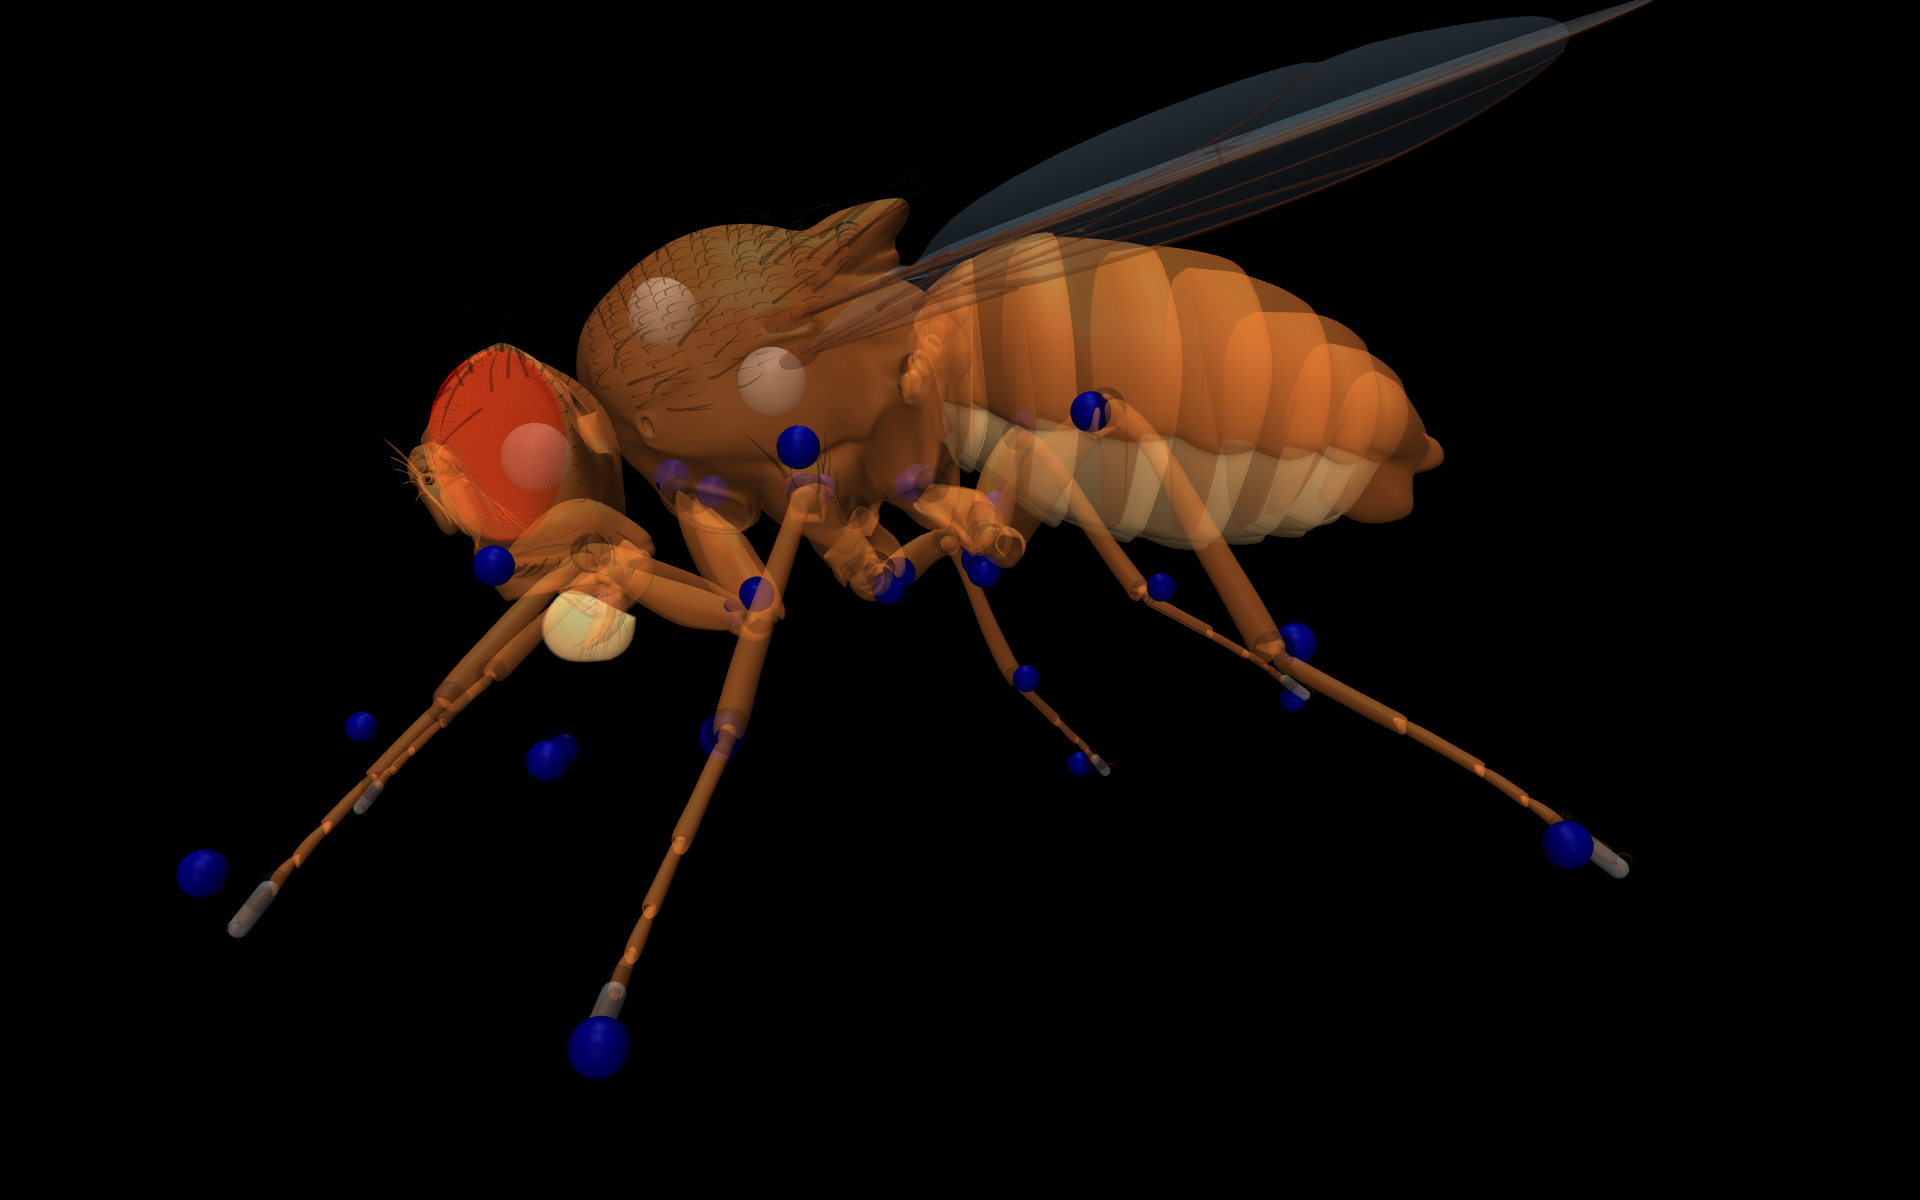

In [12]:
n = 2
scene_option.flags[enums.mjtVisFlag.mjVIS_TRANSPARENT] = True
kps = kp_data[0].reshape(-1,3).copy()

# kps[0,0] = .825
# kps[0,1] = .17
# kps[0,2] = -0.06
# kps[1,2] = -0.055
# kps[2,2] = -0.11

# kps[0,:] =+ np.array([0, -.0010, 0])
# kps[1,:] = [0, 0, 0.045]
# kps[2,:] = [-.12, 0, 0.015]
# kps[0,:] = [0, 0, 0.01]
# kps[1,:] = [0, 0, 0.075]
# kps[2,:] = [-.12, 0, 0.015]

# kps[3,:] = [0, 0, 0.01]
# kps[1,:] = [0, 0, 0.075]
# kps[2,:] = [-.12, 0, 0.015]
print(kps[n])
frames = []
# Set keypoints
render_mj_model.site_pos[keypoint_site_idxs] = kps
mj_data.qpos = qposes[0]
mujoco.mj_forward(render_mj_model, mj_data)

renderer.update_scene(mj_data, camera=5, scene_option=scene_option)
pixels = renderer.render()
PIL.Image.fromarray(pixels)

In [18]:
physics.named.data.qpos

FieldIndexer(qpos):
 0                  free [ 0       ]
 1                  free [ 0       ]
 2                  free [ 0       ]
 3                  free [ 1       ]
 4                  free [ 0       ]
 5                  free [ 0       ]
 6                  free [ 0       ]
 7  coxa_flexion_T1_left [ 0       ]
 8    coxa_twist_T1_left [ 0       ]
 9   femur_twist_T1_left [ 0       ]
10         femur_T1_left [ 0       ]
11         tibia_T1_left [ 0       ]
12 coxa_flexion_T1_right [ 0       ]
13   coxa_twist_T1_right [ 0       ]
14  femur_twist_T1_right [ 0       ]
15        femur_T1_right [ 0       ]
16        tibia_T1_right [ 0       ]
17  coxa_flexion_T2_left [ 0       ]
18    coxa_twist_T2_left [ 0       ]
19   femur_twist_T2_left [ 0       ]
20         femur_T2_left [ 0       ]
21         tibia_T2_left [ 0       ]
22 coxa_flexion_T2_right [ 0       ]
23   coxa_twist_T2_right [ 0       ]
24  femur_twist_T2_right [ 0       ]
25        femur_T2_right [ 0       ]
26        tibia_T2

In [13]:
import matplotlib.pyplot as plt
# plt.imshow(pixels)

In [14]:
# xml_path = task_path.parent / 'fruitfly_force.xml'
mjcf_model = mjcf.from_path(xml_path)
# Visualize fly as loaded.
physics = mjcf.Physics.from_mjcf_model(mjcf_model)

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = 1
scene_option.sitegroup[2] = 1

scene_option.sitegroup[3] = 1
scene_option.flags[enums.mjtVisFlag.mjVIS_TRANSPARENT] = True
# scene_option.flags[enums.mjtVisFlag.mjVIS_LIGHT] = False
# scene_option.flags[enums.mjtVisFlag.mjVIS_CONVEXHULL] = True
# scene_option.flags[enums.mjtRndFlag.mjRND_SHADOW] = False
scene_option.flags[enums.mjtRndFlag.mjRND_REFLECTION] = False
scene_option.flags[enums.mjtRndFlag.mjRND_SKYBOX] = False
scene_option.flags[enums.mjtRndFlag.mjRND_FOG] = False
# physics.model.geom('floor').pos = (0, 0, -.137)
_ = physics.reset()
# retract_wings(physics, prefix='')
# physics.step()
pixels = physics.render(camera_id=1, width=640, height=480,scene_option=scene_option)
PIL.Image.fromarray(pixels)

AttributeError: 'mujoco._structs.MjvOption' object has no attribute 'ptr'

In [ ]:
joints_to_manipulate = ['coxa_abduct_T1_left',  'coxa_twist_T1_left',   'coxa_T1_left',   'femur_T1_left',  'femur_twist_T1_left',  'tibia_T1_left',    'tarsus_T1_left',
                        'coxa_abduct_T1_right', 'coxa_twist_T1_right',  'coxa_T1_right',  'femur_T1_right', 'femur_twist_T1_right', 'tibia_T1_right',   'tarsus_T1_right',
                        'coxa_abduct_T2_left',  'coxa_twist_T2_left',   'coxa_T2_left',   'femur_T2_left',  'femur_twist_T2_left',  'tibia_T2_left',    'tarsus_T2_left',
                        'coxa_abduct_T2_right', 'coxa_twist_T2_right',  'coxa_T2_right',  'femur_T2_right', 'femur_twist_T2_right', 'tibia_T2_right',   'tarsus_T2_right',
                        'coxa_abduct_T3_left',  'coxa_twist_T3_left',   'coxa_T3_left',   'femur_T3_left',  'femur_twist_T3_left',  'tibia_T3_left',    'tarsus_T3_left',
                        'coxa_abduct_T3_right', 'coxa_twist_T3_right',  'coxa_T3_right',  'femur_T3_right', 'femur_twist_T3_right', 'tibia_T3_right',   'tarsus_T3_right',]

In [ ]:
physics.data.qpos.shape

In [ ]:
len(joints_to_manipulate), qposes.shape

In [ ]:
# Generate video of fitted poses.

camera_id = 1 # Side view.

# Hide all sites.
scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 0, 0, 0]
scene_option.flags[enums.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
scene_option.flags[enums.mjtVisFlag.mjVIS_TRANSPARENT] = True
scene_option.flags[enums.mjtVisFlag.mjVIS_LIGHT] = False
scene_option.flags[enums.mjtVisFlag.mjVIS_CONVEXHULL] = True
scene_option.flags[enums.mjtRndFlag.mjRND_SHADOW] = False
scene_option.flags[enums.mjtRndFlag.mjRND_REFLECTION] = False
scene_option.flags[enums.mjtRndFlag.mjRND_SKYBOX] = False
scene_option.flags[enums.mjtRndFlag.mjRND_FOG] = False
#retract_wings(physics)

video_frames = []
for q in tqdm(qposes[:100]):
    with physics.reset_context():
        physics.data.qpos = q.copy()
    pixels = physics.render(camera_id=camera_id, width=640, height=480, scene_option=scene_option)
    video_frames.append(pixels)

In [ ]:
media.show_video(video_frames, fps=model_cfg["RENDER_FPS"]) 

In [6]:
qvel = np.diff(qposes[:,7:], axis=0, prepend=qposes[0:1,7:])


In [7]:
qvel.shape, qposes.shape, kp_data.shape

((5700, 48), (5700, 55), (5700, 90))

In [8]:
walking_bout_n=1
root = mjcf.RootElement()
root.keyframe.add('key', name=f'walk{walking_bout_n}_1', mpos=kp_data[0].flatten(),qpos=qposes[0,7:].flatten(),qvel=qvel[0].flatten())
for n in range(2,kp_data.shape[0]):
    root.keyframe.add('key', name=f'walk{walking_bout_n}_{n}', mpos=kp_data[n].flatten(),qpos=qposes[n,7:].flatten())
    
# save xml file
keyframe_path = base_path/'models'/'fruitfly'
mjcf.export_with_assets(root, keyframe_path,f'Fly_stac_free{walking_bout_n}.xml')
keyframe_path/f'Fly_walk_pos{walking_bout_n}.xml'

PosixPath('/home/eabe/Research/MyRepos/stac-mjx/models/fruitfly/Fly_walk_pos1.xml')

# Test joint ranges

In [5]:
import matplotlib.pyplot as plt

In [ ]:
# set args
data_path = base_path / "transform.p"
xml_path = base_path / model_cfg["MJCF_PATH"]

# Load data
with open(data_path, "rb") as file:
    d = pickle.load(file)
    qposes = np.array(d["qpos"])
    kp_data = np.array(d["kp_data"])
    kp_names = d["kp_names"]
    offsets = d["offsets"]

# initialize STAC to create mj_model with scaling and marker body sites according to config
# Set the learned offsets for body sites manually
stac = STAC(xml_path, stac_cfg, model_cfg, kp_names)

In [ ]:

with open(data_path, "rb") as file:
    d = pickle.load(file)
    qposes = np.array(d["qpos"])
    kp_data = np.array(d["kp_data"])
    kp_names = d["kp_names"]
    offsets = d["offsets"]
mjcf_model = mjcf.from_path(xml_path)
physics = mjcf.Physics.from_mjcf_model(mjcf_model)
joint_ranges = physics.named.model.jnt_range
joints_to_manipulate = [j.name for j in mjcf_model.find_all('joint')]

for n,(jointrange,minjnt,maxjnt) in enumerate(zip(joint_ranges, np.min(qposes[:,6:],axis=0),np.max(qposes[:,6:],axis=0))):
    print('{},{}, xml_range: {}, min:{:.04f}, max:{:.04f}, Valid: {}'.format(n,joints_to_manipulate[n],jointrange,minjnt,maxjnt, (minjnt>=jointrange[0])&(maxjnt<=jointrange[1])))

In [ ]:
lb = stac._lb
ub = stac._ub
# Calculate min and max for each dimension
min_values = np.min(qposes, axis=0)
max_values = np.max(qposes, axis=0)

# Check if min and max violate bounds
min_violates = min_values < stac._lb
max_violates = max_values > stac._ub

# Print results
for i in range(stac._lb.shape[0]):
    print(f"Dimension {i}: ", end='')
    print(f"  Min: {min_values[i]:.4f} (Violates: {min_violates[i]})", end='')
    print(f"  Max: {max_values[i]:.4f} (Violates: {max_violates[i]})", end='')
    print(f"  Bounds: [{stac._lb[i]:.4f}, {stac._ub[i]:.4f}]", end='')
    print()

# Summary
print("Summary:")
print(f"Dimensions with min violations: {np.sum(min_violates)}")
print(f"Dimensions with max violations: {np.sum(max_violates)}")

In [13]:
mjcf_model = mjcf.from_path(xml_path)
physics = mjcf.Physics.from_mjcf_model(mjcf_model)
joint_ranges = physics.named.model.jnt_range
joints_to_manipulate = [j.name for j in mjcf_model.find_all('joint')]


In [ ]:
physics.named.data.qpos.shape

In [ ]:
joints_to_manipulate = [j.name for j in mjcf_model.find_all('joint')]
fig, axs = plt.subplots(7,6,figsize=(30, 30))
for n,ax in enumerate(axs.flatten()):
    ax.plot(qposes[:,n+7])
    ax.hlines(joint_ranges[n+1][0],0,qposes[:,7:].shape[0],'b',linestyles='dashed')
    ax.hlines(joint_ranges[n+1][1],0,qposes[:,7:].shape[0],'r',linestyles='dashed')
    ax.set_title(joints_to_manipulate[n+1])